In [1]:
from facenet_pytorch import MTCNN
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import os
import cv2
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
conf = {
    'input_dir': '../../datasets/train',
    'output_dir': '../../datasets/train_augmented',
    'batch_size': 32,
    'augmentations_per_image': 8,
    'quality': 95,
    'show_examples': True,
    'max_examples_per_person': 3
}

In [4]:
mtcnn = MTCNN(
    image_size=160, margin=20, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709,
    post_process=True, device=device
)

In [5]:
dataset = datasets.ImageFolder(conf['input_dir'],
                                transform=transforms.Compose([
                                    transforms.Resize((512, 512)),
                                    transforms.ToTensor()
                                ]))

In [6]:
len(dataset.classes)

6

In [7]:
dataset.classes

['Danh', 'DuyChien', 'GiaChien', 'Henry', 'Nguyen', 'Tu']

In [8]:
len(dataset)

260

In [9]:
for i, class_name in enumerate(dataset.classes):
    class_count = sum(1 for _, label in dataset.samples if label==i)
    print(f"{class_name}: {class_count} images")

Danh: 48 images
DuyChien: 60 images
GiaChien: 29 images
Henry: 29 images
Nguyen: 70 images
Tu: 24 images


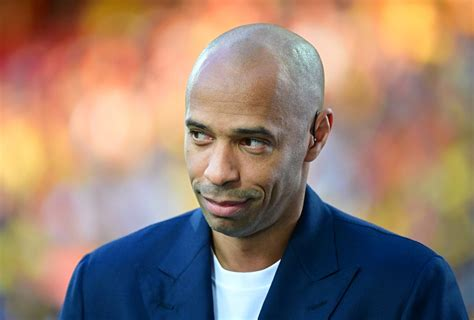

In [10]:
img = Image.open("../../datasets/train/Henry/Henry_106.jpg")
img

In [11]:
def apply_brightness(image, factor):
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(factor)

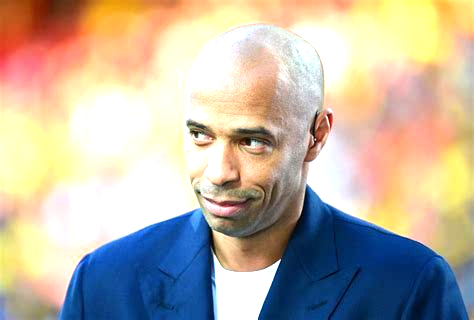

In [12]:
bright_img = apply_brightness(img, 1.5)
bright_img

In [13]:
def apply_contrast(image, factor):
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(factor)

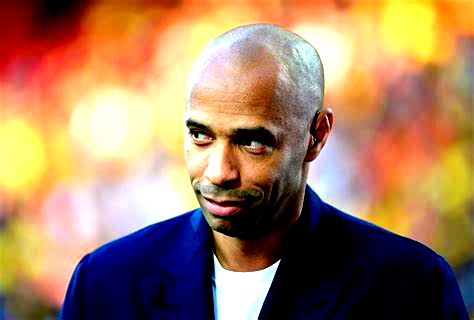

In [14]:
apply_contrast(img, 2.0)

In [15]:
def apply_saturation(image, factor):
    enhancer = ImageEnhance.Color(image)
    return enhancer.enhance(factor)

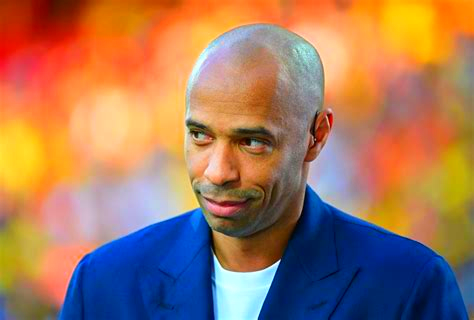

In [16]:
apply_saturation(img, 2.0)

In [17]:
def apply_blur(image, radius=0.5):
    return image.filter(ImageFilter.GaussianBlur(radius=radius))

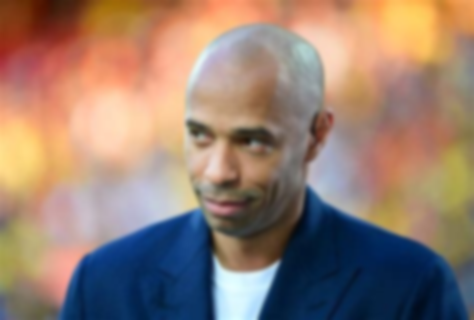

In [18]:
apply_blur(img, 2)

In [19]:
def apply_rotation(image, angle):
    return image.rotate(angle, expand=False, fillcolor=(128, 128, 128))

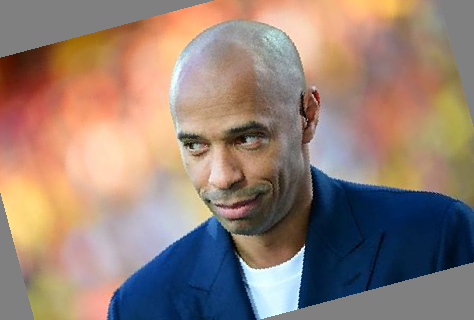

In [20]:
apply_rotation(img, 15)

In [21]:
def apply_noise(image, noise_level=5):
    img_array = np.array(image)
    noise = np.random.normal(0, noise_level, img_array.shape).astype(np.uint8)
    noisy_img = np.clip(img_array.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_img)

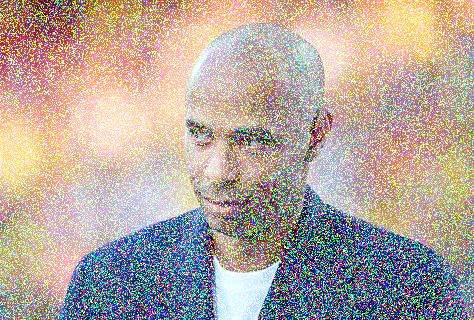

In [22]:
apply_noise(img, 2)

In [23]:
def apply_hue_shift(image, shift=10):
    img_array = np.array(image)
    hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
    hsv[:, :, 0] = (hsv[:, :, 0] + shift) % 180
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return Image.fromarray(rgb)

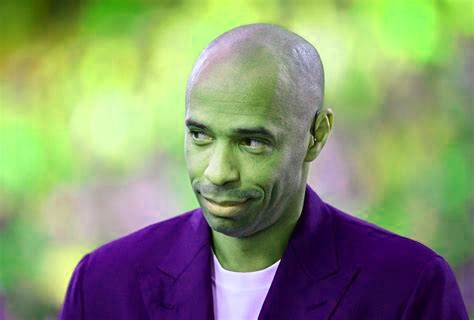

In [24]:
apply_hue_shift(img, 30)

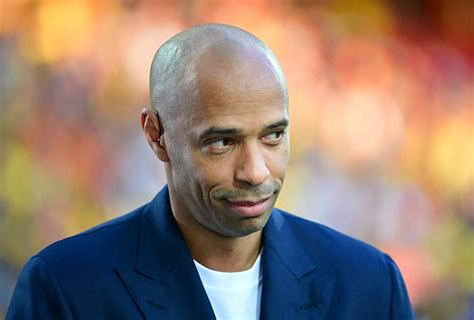

In [25]:
img.transpose(Image.FLIP_LEFT_RIGHT)

In [26]:
augs = {
    'original': lambda img: img,
    'bright_up': lambda img: apply_brightness(img, 1.3),
    'bright_down': lambda img: apply_brightness(img, 0.7),
    'contrast_up': lambda img: apply_contrast(img, 1.3),
    'contrast_down': lambda img: apply_contrast(img, 0.7),
    'saturate_up': lambda img: apply_saturation(img, 1.2),
    'saturate_down': lambda img: apply_saturation(img, 0.8),
    'blur': lambda img: apply_blur(img, 0.5),
    'flip': lambda img: img.transpose(Image.FLIP_LEFT_RIGHT),
    'rotate_left': lambda img: apply_rotation(img, 10),
    'rotate_right': lambda img: apply_rotation(img, -10),
    'noise': lambda img: apply_noise(img, 5),
    'hue_shift': lambda img: apply_hue_shift(img, 10),
}

In [27]:
def unnormalize_face_tensor(face_tensor):
    # input: [-1, 1], output: [0, 1]
    return (face_tensor + 1) / 2

In [28]:
def process_person(person_name, augmentations_per_image=8, save_to_disk=True):
    person_idx = dataset.classes.index(person_name)
    person_images = [(i, img, label) for i, (img, label) in enumerate(dataset) if label == person_idx]
    
    print(f"Processing {person_name} ({len(person_images)} images)...")
    
    if save_to_disk:
        output_person_dir = os.path.join(conf['output_dir'], person_name)
        os.makedirs(output_person_dir, exist_ok=True)
    
    stats = {
        'processed': 0,
        'faces_detected': 0,
        'augmented_created': 0,
        'errors': 0
    }
    
    for img_idx, (dataset_idx, image_tensor, _) in enumerate(tqdm(person_images, desc=f"Processing {person_name}")):
        try:
            pil_image = transforms.ToPILImage()(image_tensor)
            original_path = dataset.samples[dataset_idx][0]
            filename = os.path.basename(original_path)
            base_name = os.path.splitext(filename)[0]
            
            face_tensor = mtcnn(pil_image)
            
            if face_tensor is not None:
                stats['faces_detected'] += 1
                face_pil = transforms.ToPILImage()(unnormalize_face_tensor(face_tensor))
                
                aug_names = list(augs.keys())
                selected_augs = random.sample(aug_names, min(augmentations_per_image, len(aug_names)))
                
                if 'original' not in selected_augs:
                    selected_augs[0] = 'original'
                
                for aug_idx, aug_name in enumerate(selected_augs):
                    try:
                        augmented_face = augs[aug_name](face_pil)
                        
                        if save_to_disk:
                            if aug_name == 'original':
                                save_name = f"{base_name}.jpg"
                            else:
                                save_name = f"{base_name}_{aug_name}_{aug_idx}.jpg"
                            
                            save_path = os.path.join(output_person_dir, save_name)
                            augmented_face.save(save_path, quality=conf['quality'])
                        
                        stats['augmented_created'] += 1
                        
                    except Exception as e:
                        print(f"Error applying {aug_name}: {e}")
                        stats['errors'] += 1
            else:
                print(f"No face detected in {filename}")
            
            stats['processed'] += 1
            
        except Exception as e:
            print(f"Error processing image {img_idx}: {e}")
            stats['errors'] += 1
    
    # Print statistics
    print(f"{person_name} completed:")
    print(f"  Images processed: {stats['processed']}")
    print(f"  Faces detected: {stats['faces_detected']}")
    print(f"  Augmented images created: {stats['augmented_created']}")
    print(f"  Errors: {stats['errors']}")
    
    return stats

In [29]:
def process_all_people(augmentations_per_image=8):
    print("Processing entire dataset...")
    print(f"Configuration: {augmentations_per_image} augmentations per image")
    
    total_stats = {
        'processed': 0,
        'faces_detected': 0,
        'augmented_created': 0,
        'errors': 0
    }
    
    for person_name in dataset.classes:
        person_stats = process_person(person_name, augmentations_per_image, save_to_disk=True)
        
        for key in total_stats:
            total_stats[key] += person_stats[key]
    
    print(f"\nFinal Statistics:")
    print(f"  Total images processed: {total_stats['processed']}")
    print(f"  Total faces detected: {total_stats['faces_detected']}")
    print(f"  Total augmented images created: {total_stats['augmented_created']}")
    print(f"  Total errors: {total_stats['errors']}")
    print(f"  Success rate: {(total_stats['faces_detected']/max(1,total_stats['processed']))*100:.1f}%")
    
    return total_stats

In [30]:
process_all_people()

Processing entire dataset...
Configuration: 8 augmentations per image
Processing Danh (48 images)...


Processing Danh:   6%|▋         | 3/48 [00:00<00:04,  9.07it/s]

No face detected in 10.jpg


Processing Danh:  19%|█▉        | 9/48 [00:01<00:04,  8.88it/s]

No face detected in 16.jpg


Processing Danh:  27%|██▋       | 13/48 [00:01<00:04,  7.94it/s]

No face detected in 2.jpg


Processing Danh:  44%|████▍     | 21/48 [00:02<00:04,  6.07it/s]

No face detected in 28.jpg


Processing Danh:  79%|███████▉  | 38/48 [00:06<00:02,  4.73it/s]

No face detected in 43.jpg


Processing Danh:  96%|█████████▌| 46/48 [00:08<00:00,  7.16it/s]

No face detected in 6.jpg
No face detected in 7.jpg


Processing Danh: 100%|██████████| 48/48 [00:08<00:00,  5.73it/s]


Danh completed:
  Images processed: 48
  Faces detected: 41
  Augmented images created: 328
  Errors: 0
Processing DuyChien (60 images)...


Processing DuyChien:   2%|▏         | 1/60 [00:00<00:06,  8.93it/s]

No face detected in 10.jpg

Processing DuyChien:   5%|▌         | 3/60 [00:00<00:05, 10.48it/s]


No face detected in 11.jpg


Processing DuyChien:  12%|█▏        | 7/60 [00:00<00:06,  8.74it/s]

No face detected in 14 (1).jpg


Processing DuyChien:  22%|██▏       | 13/60 [00:01<00:08,  5.66it/s]

No face detected in 2.jpg


Processing DuyChien:  27%|██▋       | 16/60 [00:02<00:06,  6.40it/s]

No face detected in 21.jpg
No face detected in 22.jpg


Processing DuyChien:  30%|███       | 18/60 [00:02<00:05,  7.05it/s]

No face detected in 23.jpg
No face detected in 24.jpg


Processing DuyChien:  37%|███▋      | 22/60 [00:03<00:05,  7.06it/s]

No face detected in 27.jpg


Processing DuyChien:  40%|████      | 24/60 [00:03<00:04,  7.50it/s]

No face detected in 29.jpg


Processing DuyChien:  45%|████▌     | 27/60 [00:03<00:04,  7.43it/s]

No face detected in 31.jpg
No face detected in 32.jpg


Processing DuyChien:  50%|█████     | 30/60 [00:04<00:04,  7.15it/s]

No face detected in 34.jpg


Processing DuyChien:  57%|█████▋    | 34/60 [00:04<00:03,  7.42it/s]

No face detected in 38.jpg


Processing DuyChien:  73%|███████▎  | 44/60 [00:06<00:02,  7.89it/s]

No face detected in 47.jpg
No face detected in 48.jpg
No face detected in 49.jpg


Processing DuyChien:  77%|███████▋  | 46/60 [00:06<00:01,  8.16it/s]

No face detected in 5.jpg
No face detected in 50.jpg
No face detected in 51.jpg


Processing DuyChien:  82%|████████▏ | 49/60 [00:06<00:01,  8.65it/s]

No face detected in 53.jpg


Processing DuyChien:  87%|████████▋ | 52/60 [00:07<00:01,  7.03it/s]

No face detected in 55.jpg
No face detected in 56.jpg


Processing DuyChien:  90%|█████████ | 54/60 [00:07<00:00,  7.35it/s]

No face detected in 57.jpg


Processing DuyChien:  97%|█████████▋| 58/60 [00:08<00:00,  8.04it/s]

No face detected in 60.jpg


Processing DuyChien: 100%|██████████| 60/60 [00:08<00:00,  7.17it/s]

No face detected in 8.jpg
No face detected in 9.jpg
DuyChien completed:
  Images processed: 60
  Faces detected: 33
  Augmented images created: 264
  Errors: 0


Processing GiaChien (29 images)...


Processing GiaChien:  86%|████████▌ | 25/29 [00:03<00:00,  7.09it/s]

No face detected in IMG_0834.JPG


Processing GiaChien: 100%|██████████| 29/29 [00:04<00:00,  6.06it/s]


GiaChien completed:
  Images processed: 29
  Faces detected: 28
  Augmented images created: 224
  Errors: 0
Processing Henry (29 images)...


Processing Henry: 100%|██████████| 29/29 [00:05<00:00,  5.52it/s]


Henry completed:
  Images processed: 29
  Faces detected: 29
  Augmented images created: 232
  Errors: 0
Processing Nguyen (70 images)...


Processing Nguyen: 100%|██████████| 70/70 [00:16<00:00,  4.18it/s]


Nguyen completed:
  Images processed: 70
  Faces detected: 70
  Augmented images created: 560
  Errors: 0
Processing Tu (24 images)...


Processing Tu:  12%|█▎        | 3/24 [00:00<00:03,  6.46it/s]

No face detected in 10.jpg


Processing Tu: 100%|██████████| 24/24 [00:03<00:00,  6.37it/s]

Tu completed:
  Images processed: 24
  Faces detected: 23
  Augmented images created: 184
  Errors: 0

Final Statistics:
  Total images processed: 260
  Total faces detected: 224
  Total augmented images created: 1792
  Total errors: 0
  Success rate: 86.2%


{'processed': 260,
 'faces_detected': 224,
 'augmented_created': 1792,
 'errors': 0}